In [1]:
import os
import gc
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from  matplotlib import pyplot as plt

In [2]:
mvsa_single_data_path = '../input/mvsasingle/MVSA_Single/data'
mvsa_single_label_path = '../input/mvsasingle/MVSA_Single/labelResultAll.txt'
mvsa_multiple_data_path = '../input/mvsamultiple/MVSA/data'
mvsa_multiple_label_path = '../input/mvsamultiple/MVSA/labelResultAll.txt'

IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
def read_text_file(path, multi_line=False):
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
    return open(path, 'r', encoding='latin-1').read()

def read_image_file(path):
    try:
        image = cv2.imread(path)[:, :, ::-1] #, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)

#         image = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
#         image = tf.keras.preprocessing.image.img_to_array(image)
        invalid_ID = -1
    except:
        image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
        invalid_ID = int(os.path.split(path)[1].split('.')[0])
    return image, invalid_ID

def read_labels_file(path):
    dataframe = pd.read_csv(path, sep="\s+|,", engine="python")
    return dataframe

In [4]:
def get_data_paths(path, extension):
    ''' Get list of data paths with input extension and sort by its filename (ID)
    path: Folder path
    extension: File extension wants to get
    '''
    paths = os.listdir(path)
    paths = list(filter(lambda x: x.endswith(extension), paths))
    paths.sort(key = lambda x : int(x.split('.')[0]))
    paths = [os.path.join(path, x) for x in paths]
    return paths

def get_image_with_id(path):
    filename = os.path.split(path)[1]
    ID = int(filename.split('.')[0])
    image = read_image_file(path)
    return (ID, image)

In [5]:
# there are 3 annotators labelling each modality labels in the MVSA-Multiple dataset
# merge those 3 label pairs into 1 pair by taking majority vote on each modality label
# since there are only 3 different labels, if 1 modality receives 3 different labels from 3 annotators
# => the data pair contains it is considered invalid
def merge_multi_label(dataframe):
    anno_1 = list(dataframe.loc[:, ['text', 'image']].itertuples(index=False, name=None))
    anno_2 = list(dataframe.loc[:, ['text.1', 'image.1']].itertuples(index=False, name=None))
    anno_3 = list(dataframe.loc[:, ['text.2', 'image.2']].itertuples(index=False, name=None))
    IDs = list(dataframe.iloc[:, 0])
    
    valid_pairs = []
    
    for i in range(len(anno_1)):
        pairs = [anno_1[i], anno_2[i], anno_3[i]]
        ID = IDs[i]
        
        text_labels = [pair[0] for pair in pairs]
        image_labels = [pair[1] for pair in pairs]
        
        max_occur_text_label = max(text_labels, key=text_labels.count)
        max_occur_image_label = max(image_labels, key=image_labels.count)

        if text_labels.count(max_occur_text_label) > 1 and image_labels.count(max_occur_image_label) > 1:
            valid_pair = (ID, max_occur_text_label, max_occur_image_label)
        else:
            valid_pair = (ID, 'invalid', 'invalid')
        valid_pairs.append(valid_pair)
    valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
    return valid_dataframe

def multimodal_label(text_label, image_label):
    if text_label == image_label:
        label = text_label
    elif (text_label == 'positive' and image_label == 'negative') or (text_label == 'negative' and image_label == 'positive'):
        label = 'invalid'
    elif (text_label == 'neutral' and image_label != 'neutral') or (text_label != 'neutral' or image_label == 'neutral'):
        label = image_label if text_label == 'neutral' else text_label
    return label

In [6]:
def create_multimodal_labels(path, multiple=False, mappings=False):
    dataframe = read_labels_file(path)
    
    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    labels = []
    for label_pair in dataframe.loc[:, ['text', 'image']].values:
        label = multimodal_label(label_pair[0], label_pair[1])
        labels.append(label)
        
    if mappings == True:
        label_map = {}
        for i in range(len(labels)):
            ID = dataframe.iloc[i, 0]
            label_map[ID] = labels[i]            
        return label_map
    
    return np.array(labels, dtype='object')

def create_original_labels(path, multiple=False):
    dataframe = read_labels_file(path)
    
    if multiple == True:
        dataframe = merge_multi_label(dataframe)
        
    text_labels = dataframe['text'].to_numpy()
    image_labels = dataframe['image'].to_numpy()
    return text_labels, image_labels

def create_text_data(path):
    texts = []
    text_paths = get_data_paths(path, '.txt')
    
    print('Read text data')
    for text_path in tqdm(text_paths):
        text = read_text_file(text_path).rstrip('\n')
        texts.append(text)

    return texts

def create_image_data(path):
    images = []
    invalid_indices = []
    image_paths = get_data_paths(path, '.jpg')

    print('Read image data')
    for image_path in tqdm(image_paths):
        image, invalid_ID = read_image_file(image_path)
        images.append(image)

        if invalid_ID != -1:
            invalid_indices.append(invalid_ID)
            
    images = np.array(images, dtype='uint8')
    return images, invalid_indices

In [7]:
def remove_invalid(data, indices):
    valid_data = []
    for i in range(len(data)):
        if i not in indices:
            valid_data.append(data[i])
    return valid_data

In [8]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('utf-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [9]:
def load_mvsa_data(path):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
            
    images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
    npzfile = np.load(images_path)
    images = npzfile['arr_0']
        
    return texts, images, labels, text_labels, image_labels

# Read and process raw data

## MVSA-Single

In [10]:
mvsa_single_texts = create_text_data(mvsa_single_data_path)
mvsa_single_images, mvsa_single_images_invalid_indices = create_image_data(mvsa_single_data_path)
mvsa_single_multimodal_labels = create_multimodal_labels(mvsa_single_label_path)
mvsa_single_text_labels, mvsa_single_image_labels = create_original_labels(mvsa_single_label_path)
num_mvsa_single = len(mvsa_single_texts)

Read text data


100%|██████████| 4869/4869 [00:13<00:00, 361.33it/s]


Read image data


100%|██████████| 4869/4869 [01:16<00:00, 63.35it/s]


In [11]:
# Get duplicated text indices
# mvsa_single_texts_unique_indices = np.unique(mvsa_single_texts, return_index=True)[1]
# mvsa_single_texts_duplicated_indices = [i for i in range(num_mvsa_single) if i not in mvsa_single_texts_unique_indices]

# Get invalid label indices
mvsa_single_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_single) if mvsa_single_multimodal_labels[i] == 'invalid']

In [12]:
print('Number of text-image pair in MVSA-Single:', num_mvsa_single)

mvsa_single_invalid_indices = []
# mvsa_single_invalid_indices.extend(mvsa_single_texts_duplicated_indices)
mvsa_single_invalid_indices.extend(mvsa_single_images_invalid_indices) # corrupted images
mvsa_single_invalid_indices.extend(mvsa_single_multimodal_labels_invalid_indices)
mvsa_single_invalid_indices = list(set(mvsa_single_invalid_indices))
print('Number of invalid data in MVSA-Single:', len(mvsa_single_invalid_indices))

mvsa_single_texts_valid = remove_invalid(mvsa_single_texts, mvsa_single_invalid_indices)
mvsa_single_images_valid = remove_invalid(mvsa_single_images, mvsa_single_invalid_indices)
mvsa_single_multimodal_labels_valid = remove_invalid(mvsa_single_multimodal_labels, mvsa_single_invalid_indices)
mvsa_single_text_labels_valid = remove_invalid(mvsa_single_text_labels, mvsa_single_invalid_indices)
mvsa_single_image_labels_valid = remove_invalid(mvsa_single_image_labels, mvsa_single_invalid_indices)

num_mvsa_single_valid = len(mvsa_single_texts_valid)
print('Number of text-image pair in MVSA-Single after removing invalid data:', num_mvsa_single_valid)

Number of text-image pair in MVSA-Single: 4869
Number of invalid data in MVSA-Single: 358
Number of text-image pair in MVSA-Single after removing invalid data: 4511


In [13]:
# save and load check data
with h5py.File('mvsa-single-{}.hdf5'.format(num_mvsa_single_valid), 'w') as f:
    f.create_dataset('texts', data = mvsa_single_texts_valid)
#     f.create_dataset('images', data = mvsa_single_images_valid)
    f.create_dataset('multimodal-labels', data = mvsa_single_multimodal_labels_valid)
    f.create_dataset('text-labels', data = mvsa_single_text_labels_valid)
    f.create_dataset('image-labels', data = mvsa_single_image_labels_valid)
    
np.savez('./mvsa-single-{}-images'.format(num_mvsa_single_valid), mvsa_single_images_valid)
    
mvsa_single_texts_loaded, mvsa_single_images_loaded, \
mvsa_single_multimodal_labels_loaded, mvsa_single_text_labels_loaded, \
mvsa_single_image_labels_loaded = load_mvsa_data('./mvsa-single-{}.hdf5'.format(num_mvsa_single_valid))

print((mvsa_single_texts_valid == mvsa_single_texts_loaded).all())
print((mvsa_single_images_valid == mvsa_single_images_loaded).all())
print((mvsa_single_multimodal_labels_valid == mvsa_single_multimodal_labels_loaded).all())
print((mvsa_single_text_labels_valid == mvsa_single_text_labels_loaded).all())
print((mvsa_single_image_labels_valid == mvsa_single_image_labels_loaded).all())

True
True
True
True
True


## MVSA-Multiple

In [14]:
mvsa_multiple_texts = create_text_data(mvsa_multiple_data_path)
mvsa_multiple_images, mvsa_multiple_images_invalid_indices = create_image_data(mvsa_multiple_data_path)
mvsa_multiple_multimodal_labels = create_multimodal_labels(mvsa_multiple_label_path, multiple=True)
mvsa_multiple_text_labels, mvsa_multiple_image_labels = create_original_labels(mvsa_multiple_label_path, multiple=True)
num_mvsa_multiple = len(mvsa_multiple_texts)

Read text data


100%|██████████| 19600/19600 [00:57<00:00, 339.61it/s]


Read image data


100%|██████████| 19600/19600 [05:34<00:00, 58.53it/s]


In [15]:
# Get duplicated text indices
# mvsa_multiple_texts_unique_indices = np.unique(mvsa_multiple_texts, return_index=True)[1]
# mvsa_multiple_texts_duplicated_indices = [i for i in range(num_mvsa_multiple) if i not in mvsa_multiple_texts_unique_indices]

# Get invalid label indices
mvsa_multiple_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_multiple) if mvsa_multiple_multimodal_labels[i] == 'invalid']

In [16]:
print('Number of text-image pair in MVSA-Multiple:', num_mvsa_multiple)

mvsa_multiple_invalid_indices = []
# mvsa_multiple_invalid_indices.extend(mvsa_multiple_texts_duplicated_indices)
mvsa_multiple_invalid_indices.extend(mvsa_multiple_images_invalid_indices)
mvsa_multiple_invalid_indices.extend(mvsa_multiple_multimodal_labels_invalid_indices)
mvsa_multiple_invalid_indices = list(set(mvsa_multiple_invalid_indices))
print('Number of invalid data in MVSA-Multiple:', len(mvsa_multiple_invalid_indices))

mvsa_multiple_texts_valid = remove_invalid(mvsa_multiple_texts, mvsa_multiple_invalid_indices)
mvsa_multiple_images_valid = remove_invalid(mvsa_multiple_images, mvsa_multiple_invalid_indices)
mvsa_multiple_multimodal_labels_valid = remove_invalid(mvsa_multiple_multimodal_labels, mvsa_multiple_invalid_indices)
mvsa_multiple_text_labels_valid = remove_invalid(mvsa_multiple_text_labels, mvsa_multiple_invalid_indices)
mvsa_multiple_image_labels_valid = remove_invalid(mvsa_multiple_image_labels, mvsa_multiple_invalid_indices)

num_mvsa_multiple_valid = len(mvsa_multiple_texts_valid)
print('Number of text-image pair in MVSA-Multiple after removing invalid data:', num_mvsa_multiple_valid)

Number of text-image pair in MVSA-Multiple: 19600
Number of invalid data in MVSA-Multiple: 2576
Number of text-image pair in MVSA-Multiple after removing invalid data: 17024


In [17]:
# save data to file
with h5py.File('mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid), 'w') as f:
    f.create_dataset('texts', data = mvsa_multiple_texts_valid)
#     f.create_dataset('images', data = a, compression="gzip")
    f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
    f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
    f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)
    
# save as npz since h5py has a memory issues when saving upto 16k data somehow but 13k was fine :)
np.savez('./mvsa-multiple-{}-images'.format(num_mvsa_multiple_valid), mvsa_multiple_images_valid)

In [18]:
mvsa_multiple_texts_loaded, mvsa_multiple_images_loaded, \
mvsa_multiple_multimodal_labels_loaded, mvsa_multiple_text_labels_loaded, \
mvsa_multiple_image_labels_loaded = load_mvsa_data('./mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid))

In [19]:
print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
print((mvsa_multiple_images_valid == mvsa_multiple_images_loaded).all())
print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())
print((mvsa_multiple_text_labels_valid == mvsa_multiple_text_labels_loaded).all())
print((mvsa_multiple_image_labels_valid == mvsa_multiple_image_labels_loaded).all())

True
True
True
True
True


# Visualization

In [20]:
mvsa_single_multimodal_labels_valid = np.array(mvsa_single_multimodal_labels_valid)
mvsa_multiple_multimodal_labels_valid = np.array(mvsa_multiple_multimodal_labels_valid)

In [21]:
mvsa_single_num_pos = (mvsa_single_multimodal_labels_valid == 'positive').sum()
mvsa_single_num_neg = (mvsa_single_multimodal_labels_valid == 'negative').sum()
mvsa_single_num_neu = (mvsa_single_multimodal_labels_valid == 'neutral').sum()

mvsa_multiple_num_pos = (mvsa_multiple_multimodal_labels_valid == 'positive').sum()
mvsa_multiple_num_neg = (mvsa_multiple_multimodal_labels_valid == 'negative').sum()
mvsa_multiple_num_neu = (mvsa_multiple_multimodal_labels_valid == 'neutral').sum()

In [22]:
def get_label_num(data_labels, name=''):
    unique_labels = np.unique(data_labels)
    num_labels = [(data_labels == label).sum() for label in  unique_labels]
    dataframe = pd.DataFrame(np.reshape(num_labels, (1, -1)), columns=unique_labels, index=[name])
    return dataframe

In [23]:
print('MVSA dataset after removing invalid and duplicated data')
mvsa_single_valid_label = get_label_num(mvsa_single_multimodal_labels_valid, 'MVSA-Single')
mvsa_multiple_valid_label = get_label_num(mvsa_multiple_multimodal_labels_valid, 'MVSA-Multiple')
mvsa_valid_label = get_label_num(np.append(mvsa_single_multimodal_labels_valid, mvsa_multiple_multimodal_labels_valid, axis=0), 'Total MVSA')
mvsa_valid_label = pd.concat([mvsa_single_valid_label, mvsa_multiple_valid_label, mvsa_valid_label])
mvsa_valid_label['total'] = mvsa_valid_label.sum(axis = 1)
mvsa_valid_label

MVSA dataset after removing invalid and duplicated data


,negative,neutral,positive,total
MVSA-Single,1358,470,2683,4511
MVSA-Multiple,1299,4407,11318,17024
Total MVSA,2657,4877,14001,21535


In [24]:
positive_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'positive']
negative_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'negative']
neutral_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_valid[i] == 'neutral']

Positive images


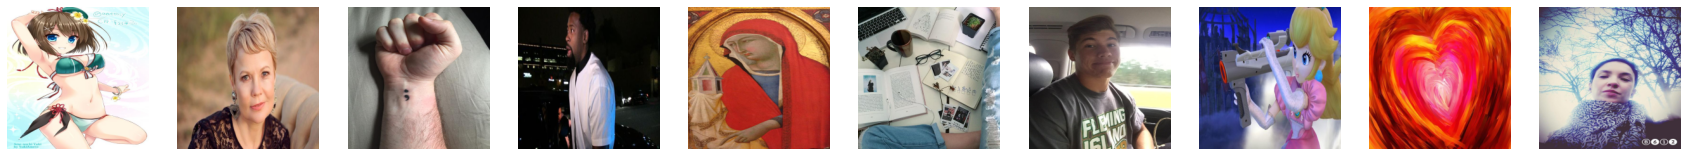

In [25]:
rows = 1
columns = 10

fig = plt.figure(figsize=(30, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    positive_image_indices
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index])
    plt.axis('off')
plt.show()

Negative images


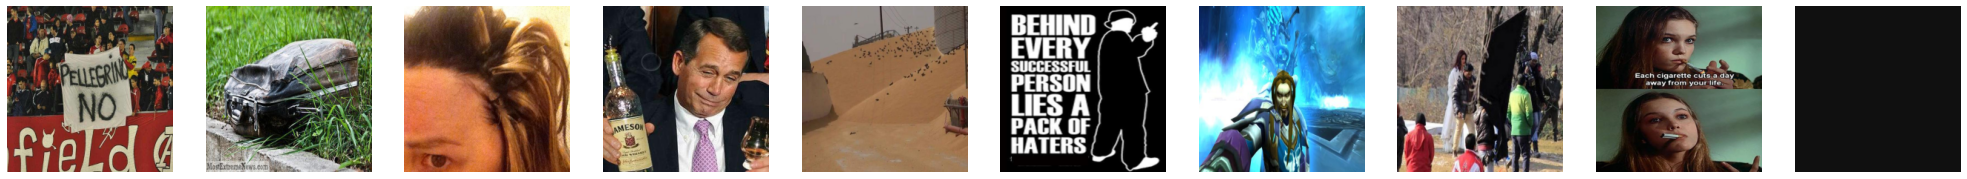

In [26]:
fig = plt.figure(figsize=(35, 10))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index])
    plt.axis('off')
plt.show()

Neutral images


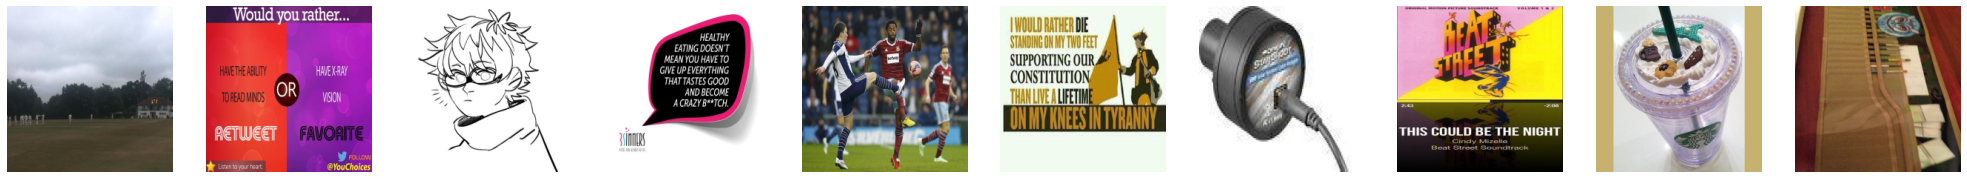

In [27]:
fig = plt.figure(figsize=(35, 10))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_valid[random_index])
    plt.axis('off')
plt.show()

# Drafts

In [28]:
# def save_text_file(filename, lines):
#     with open(filename, 'w', encoding='latin-1') as f:
#         f.write('\n'.join(lines))

# for loading saved output data
# def load_mvsa_data(path):
#     read_file = h5py.File(path, 'r')
    
#     texts = read_file['texts'][:]
#     texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
#     images = read_file['images'][:]
    
#     multimodal_labels = read_file['multimodal-labels'][:]
#     multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

#     text_labels = read_file['text-labels'][:]
#     text_labels = np.array([x.decode('UTF-8') for x in text_labels])

#     image_labels = read_file['image-labels'][:]
#     image_labels = np.array([x.decode('UTF-8') for x in image_labels])

#     return texts, images, multimodal_labels, text_labels, image_labels

In [29]:
# # for loading saved output data JUST GOT OLD
# def load_mvsa_multiple(path): # temporary fix
#     read_file = h5py.File(path, 'r')
    
#     texts = read_file['texts'][:]
#     texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
# #     images = read_file['images'][:]
    
#     multimodal_labels = read_file['multimodal-labels'][:]
#     multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

#     text_labels = read_file['text-labels'][:]
#     text_labels = np.array([x.decode('UTF-8') for x in text_labels])

#     image_labels = read_file['image-labels'][:]
#     image_labels = np.array([x.decode('UTF-8') for x in image_labels])

#     return texts, multimodal_labels, text_labels, image_labels


# npzfile = np.load('./mvsa-multiple-{}-images.npz'.format(num_mvsa_multiple_valid))
# mvsa_multiple_images_loaded = npzfile['arr_0']

In [30]:
# def old_merge_multi_label(dataframe):
#     anno_1 = list(dataframe.iloc[:, 1:3].itertuples(index=False, name=None))
#     anno_2 = list(dataframe.iloc[:, 3:5].itertuples(index=False, name=None))
#     anno_3 = list(dataframe.iloc[:, 5:7].itertuples(index=False, name=None))
#     IDs = list(dataframe.iloc[:, 0])
#     valid_pairs = []
#     for i in range(len(anno_1)):
#         pairs = [anno_1[i], anno_2[i], anno_3[i]]
#         ID = IDs[i]
#         valid_pair = tuple([pair for pair in pairs if pairs.count(pair) > 1])
#         if len(valid_pair) == 0:
#             valid_pair = (ID, 'invalid', 'invalid')
#         else:
#             valid_pair = (ID, valid_pair[0][0], valid_pair[0][1])
#         valid_pairs.append(valid_pair)
#     valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
#     return valid_dataframe

In [31]:
# def prenp_create_image_data(path):
#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')
#     images = np.zeros((len(image_paths), IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))

#     i = 0
#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
        
#         images[i] = image
#         i+=1
#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

# def np_create_image_data(path):
#     images = np.array([])

#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')

#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
#         if images.shape[0] == 0:
#             images = np.array([image])
#         else:
#             images = np.concatenate((images, [image]))

#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

In [32]:
# def old_remove_invalid(data, indices):
#     new_data =  np.delete(data, indices, axis=0)
#     return new_data

In [33]:
# def old_create_image_data(path):
#     images = np.array([])

#     invalid_indices = []
#     image_paths = get_data_paths(path, '.jpg')

#     print('Read image data')
#     for image_path in tqdm(image_paths):
#         image, invalid_ID = read_image_file(image_path)
#         if images.shape[0] == 0:
#             images = np.array([image])
#         else:
#             images = np.concatenate((images, [image]))

#         if invalid_ID != -1:
#             invalid_indices.append(invalid_ID)
            
#     return images, invalid_indices

In [34]:
# # save_text_file('./mvsa-multiple-texts.txt', mvsa_multiple_texts_valid)
# np.save('./mvsa-multiple-images.npy', mvsa_multiple_images_valid)
# # save_text_file('./mvsa-multiple-labels.txt', mvsa_multiple_multimodal_labels_valid)

# # mvsa_multiple_texts_loaded = read_text_file('./mvsa-multiple-texts.txt', multi_line=True)
# mvsa_multiple_images_loaded = np.load('./mvsa-multiple-images.npy')
# # mvsa_multiple_multimodal_labels_loaded = read_text_file('./mvsa-multiple-labels.txt', multi_line=True)

# # print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
# print((mvsa_multiple_images_loaded == mvsa_multiple_images_valid).all())
# # print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())

In [35]:
# # Open HDF5 and create datasets in advance
# save_file = h5py.File('mvsa-multiple-{}.hdf5'.format(mvsa_multiple_texts_valid.shape[0]), 'w')
# save_file.create_dataset("data_image", (200000,224,224), dtype='uint8')
# save_file.create_dataset("data_label", (200000,), dtype='int64')
# f.create_dataset('texts', len(mvsa_multiple_texts_valid), dtype='object')
# f.create_dataset('images', data = mvsa_multiple_images_valid)
# f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
# f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
# f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)

# label_list = os.listdir('root')
# img_cnt = 0
# for i, label in enumerate(label_list):
#     files = os.listdir(os.path.join('root', label_list))
#     for filename in files:
#         img = Image.open(os.path.join('root', label, filename))
#         ow, oh = 128, 128
#         img = img.resize((ow, oh), Image.BILINEAR)
#         save_file["data_image"][img_cnt,:,:] = np.array(img).tolist())
#         save_file["data_label"][img_cnt] = i
#         img_cnt += 1

# datafile.close()

In [36]:
# save_text_file('./mvsa-multiple-texts.txt', mvsa_multiple_texts_valid)
# np.save('./mvsa-multiple-images.npy', mvsa_multiple_images_valid)
# save_text_file('./mvsa-multiple-labels.txt', mvsa_multiple_multimodal_labels_valid)

# mvsa_multiple_texts_loaded = read_text_file('./mvsa-multiple-texts.txt', multi_line=True)
# mvsa_multiple_images_loaded = np.load('./mvsa-multiple-images.npy')
# mvsa_multiple_multimodal_labels_loaded = read_text_file('./mvsa-multiple-labels.txt', multi_line=True)

# print((mvsa_multiple_texts_valid == mvsa_multiple_texts_loaded).all())
# print((mvsa_multiple_images_loaded == mvsa_multiple_images_valid).all())
# print((mvsa_multiple_multimodal_labels_valid == mvsa_multiple_multimodal_labels_loaded).all())

In [37]:
## OLD SAVE AND LOAD DATA WITH NPY FILE

# save_text_file('./mvsa-single-texts.txt', mvsa_single_texts_valid)
# np.save('./mvsa-single-images.npy', mvsa_single_images_valid)
# save_text_file('./mvsa-single-labels.txt', mvsa_single_multimodal_labels_valid)

# mvsa_single_texts_loaded = read_text_file('./mvsa-single-texts.txt', multi_line=True)
# mvsa_single_images_loaded = np.load('./mvsa-single-images.npy')
# mvsa_single_multimodal_labels_loaded = read_text_file('./mvsa-single-labels.txt', multi_line=True)

In [38]:
# mvsa_single_images_unique_indices = np.unique([image.flatten() for image in mvsa_single_images], return_index=True, return_counts=True)
# mvsa_single_images_duplicated_indices = [i for i in range(mvsa_single_images.shape[0]) if i not in mvsa_single_images_unique_indices]

## ---> doesn't work, only compare unique numbers not unique list

In [39]:
# if extracted_data.shape[0] == 0:
#     extracted_data = np.concatenate(([extracted_data], [features]), 1)
# else:
#     extracted_data = np.concatenate((extracted_data, [features]), 0)

In [40]:
# # mvsa_single_images.tofile('./mvsa-single-images.npy')
# np.save('./mvsa-single-images.npy', mvsa_single_images)
# mvsa_single_images_loaded = np.load('./mvsa-single-images.npy')
# (mvsa_single_images_loaded == mvsa_single_images).all()

In [41]:
# a = read_labels_file(mvsa_single_label_path).iloc[:, 1:].values
# for i in a:
#     if i[0] == 'negative' and i[1] == 'positive':
#         print('here')
#     elif i[0] == 'positive' and i[1] == 'negative':
#         print('hereee')

In [42]:
# label_mappings = create_labels(mvsa_single_label_path, mappings=True)

# image_dataset = make_dataset([os.path.join(mvsa_single_label_path, str(ID) + '.jpg') for ID in label_mappings.keys()],
#                              list(label_mappings.values()))

In [43]:
# a = get_image_with_id(os.path.join(mvsa_single_data_path, '1.jpg'))
# tf.keras.utils.array_to_img(a[1])

In [44]:
# label_mappings = create_labels(mvsa_single_label_path, mappings=True)

# image_dataset = make_dataset([os.path.join(mvsa_single_label_path, str(ID) + '.jpg') for ID in label_mappings.keys()],
#                              list(label_mappings.values()))

In [45]:
# # a = create_labels(mvsa_multiple_label_path, multiple=True, mappings=True)
# def process_image(path, label):
# #     filename = os.path.split(path)[1]
# #     ID = int(filename.split('.')[0])
# #     return read_image_file(path), label_map[ID]
#     return read_image_file(path), label

# def make_dataset(images, labels):
#     dataset = tf.data.Dataset.from_tensor_slices((images, labels))
# #     dataset = dataset.shuffle(len(images))
#     dataset = dataset.map(process_image)#, num_parallel_calls=AUTOTUNE)
# #     dataset = dataset.batch(100).prefetch(tf.data.AUTOTUNE)
#     return dataset